# Descripción del proyecto

<div class="alert alert-block" style="background-color: #D8BFD8; color: #374151;">
Trabajas en una empresa emergente que vende productos alimenticios. 

Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). 
Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.


### Paso 1. Abrir el archivo de datos y leer la información general


In [767]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from scipy import stats
from scipy.stats import ttest_ind
import matplotlib.dates as mdates

In [768]:
data = pd.read_csv('logs_exp_us.csv', sep="\t")

In [769]:
#Se define EDA función para explorar los datos.

def EDA(datos):
    print("Primeras Filas")
    print(datos.head())
    print()
    print("Datos Generales")
    print(datos.info())
    print()
    print("Revision de Datos Ausentes")
    print(datos.isna().sum())
    print()
    print("Filas Duplicadas")
    print(datos.duplicated().sum())

In [770]:
EDA(data)

Primeras Filas
                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Datos Generales
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

Revision de Datos Ausentes
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0

### Paso 2. Preparar los datos para el análisis
Cambia el nombre de las columnas de manera que sea conveniente para ti.
Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.
Agrega una columna de fecha y hora y una columna separada para las fechas.

In [772]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [773]:
data.columns = ['event', 'user','timestamp','exp_id']

In [774]:
data.head()

,event,user,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [775]:
data['datetime'] = pd.to_datetime(data['timestamp'], unit = 's')

In [776]:
data['date'] = data['datetime'].dt.floor('1D')

In [777]:
data.head()

,event,user,timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Paso 3. Estudiar y comprobar los datos	
¿Cuántos eventos hay en los registros?

In [779]:
# Conteo de cada tipo de evento
eventos_unicos = data_clean['event'].nunique()
print(f"Tipos de Eventos: {eventos_unicos}")

Tipos de Eventos: 5


In [780]:
# Tipos de Eventos
list(data['event'].unique())

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear',
 'Tutorial']

¿Cuántos usuarios hay en los registros?


In [782]:
usuarios = data['user'].nunique()
print(f"Total de Usuarios: {usuarios}")

Total de Usuarios: 7551


¿Cuál es el promedio de eventos por usuario?

In [784]:
len(data)/data['user'].nunique()

32.33028737915508

<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
En promedio, se observan 32 usuarios por evento, aunque esta cifra puede variar hacia arriba o hacia abajo dependiendo de las circunstancias específicas de cada evento.

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Excelente inicio en la preparación de los datos! Tu enfoque para explorar y organizar la información es sólido y demuestra un buen manejo de las herramientas y conceptos básicos de análisis de datos.

✅ **Puntos positivos:**
1. **Función EDA clara y reutilizable:** La función definida para explorar los datos iniciales es muy útil. Permite inspeccionar aspectos clave como valores nulos, duplicados y una visión general del dataset.
2. **Renombrar columnas:** Cambiar los nombres de las columnas para que sean más convenientes y claros es una práctica excelente para mantener consistencia y claridad en el análisis.
3. **Conversión de tipos de datos:** Convertir `timestamp` a un formato datetime y agregar columnas como `datetime` y `date` demuestra una correcta preparación para análisis posteriores.
4. **Exploración inicial del dataset:** El cálculo de usuarios únicos, eventos únicos y el promedio de eventos por usuario establece una buena base para evaluar el comportamiento de los datos.

---

⚠️ **Sugerencias de mejora:**
1. **Documentación en los pasos:** Agrega comentarios o notas explicativas dentro del código para que sea más fácil de seguir. Por ejemplo, explica brevemente por qué agregas la columna `date` separada de `datetime`.
2. **Validación de datos:** Aunque verificaste valores ausentes y duplicados, sería útil incluir una tabla resumen o gráfico rápido para visualizar las proporciones de datos faltantes (por ejemplo, con un heatmap de `sns.heatmap(data.isna(), cmap="viridis")`).
3. **Verificación de valores únicos:** Cuando exploras los eventos únicos (`data['event'].unique()`), podrías también contar la frecuencia de cada uno para priorizar los eventos más relevantes.
4. **Formato de salida:** Considera imprimir los resultados de una manera más organizada. Por ejemplo, los nombres de los eventos pueden imprimirse en un listado limpio para facilitar la interpretación.

---

En general, esta sección está bien implementada y proporciona una base sólida para el análisis posterior. 
</div>

¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora.

In [787]:
# Obtener la fecha mínima y máxima en los datos
fecha_min = data['datetime'].min()
fecha_max = data['datetime'].max()

print(f"Los datos cubren desde {fecha_min} hasta {fecha_max}")

Los datos cubren desde 2019-07-25 04:43:36 hasta 2019-08-07 21:15:17


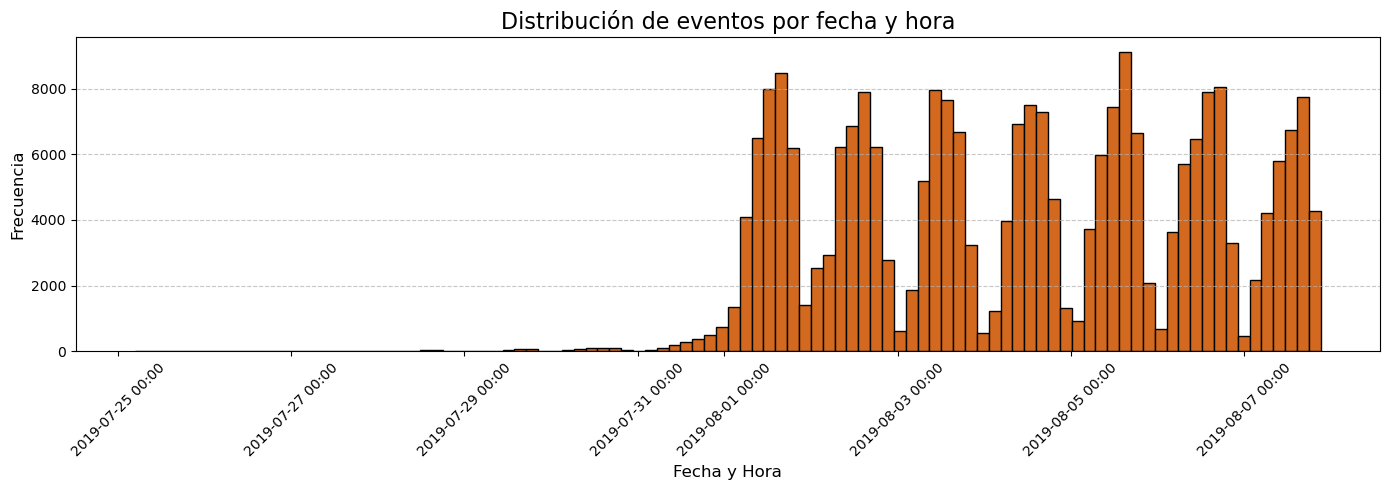

In [788]:
plt.figure(figsize=(14, 5))
plt.hist(data['datetime'], bins=100, color='chocolate', edgecolor='black')

# Formato del eje X para mostrar fecha y hora
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Autoajuste de intervalos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Fecha y hora

plt.xticks(rotation=45)  # Rotar etiquetas para mejor lectura
plt.title('Distribución de eventos por fecha y hora', fontsize=16)
plt.xlabel('Fecha y Hora', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar una cuadrícula sutil en el eje Y

plt.tight_layout()
plt.show()

In [789]:
#Revisemos cuantos usuarios hay por fecha
usuarios_por_fecha = data.groupby(data['datetime'].dt.date)['user'].nunique()
usuarios_por_fecha

datetime
2019-07-25       7
2019-07-26      22
2019-07-27      39
2019-07-28      69
2019-07-29     135
2019-07-30     296
2019-07-31     924
2019-08-01    3703
2019-08-02    3647
2019-08-03    3482
2019-08-04    3527
2019-08-05    3802
2019-08-06    3922
2019-08-07    3651
Name: user, dtype: int64

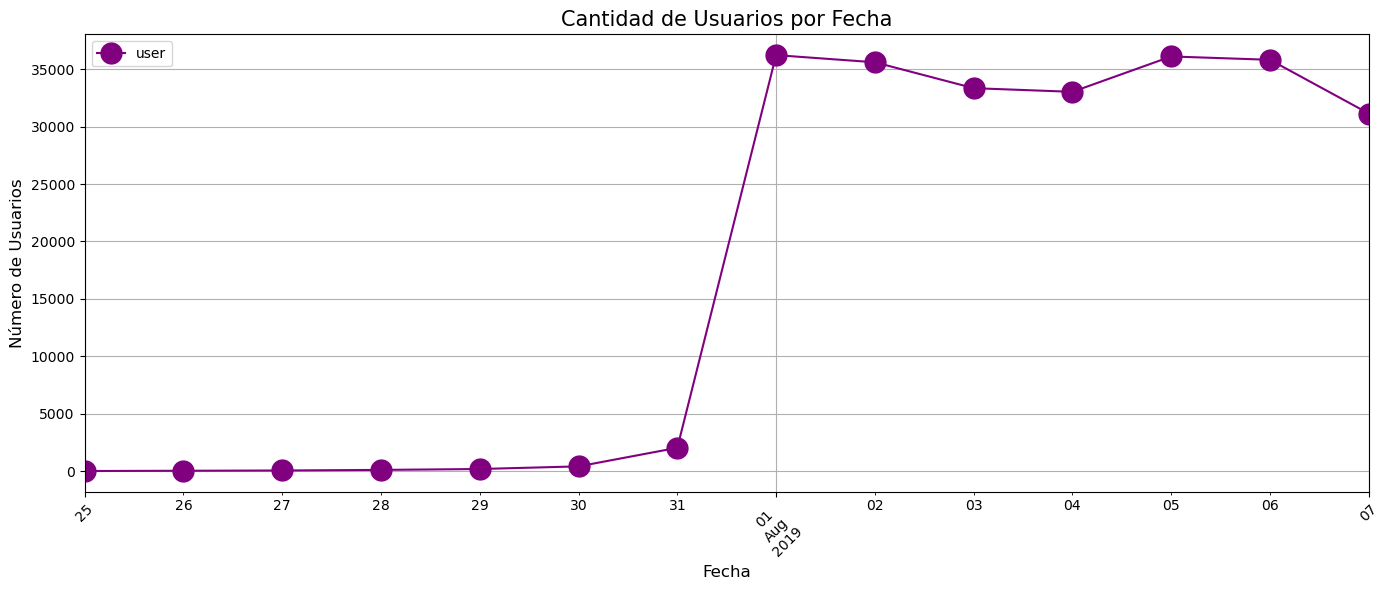

In [790]:
#tabla dinámica con el conteo de usuarios por fecha
pivot = data.pivot_table(index='date', values='user', aggfunc='count')
pivot.plot(style='o-', grid=True, figsize=(14, 6), color='purple', markersize=15)
plt.title('Cantidad de Usuarios por Fecha', fontsize=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
Se observa un incremento en los datos a partir del 1 de agosto, por lo que se utilizará la información a partir de esa fecha para continuar con el análisis

In [793]:
data_clean = data.query('datetime >= "2019-08-01"').reset_index()

In [794]:
usuarios_por_fecha2 = data_clean.groupby(data_clean['datetime'].dt.date)['user'].nunique()
usuarios_por_fecha2

datetime
2019-08-01    3703
2019-08-02    3647
2019-08-03    3482
2019-08-04    3527
2019-08-05    3802
2019-08-06    3922
2019-08-07    3651
Name: user, dtype: int64

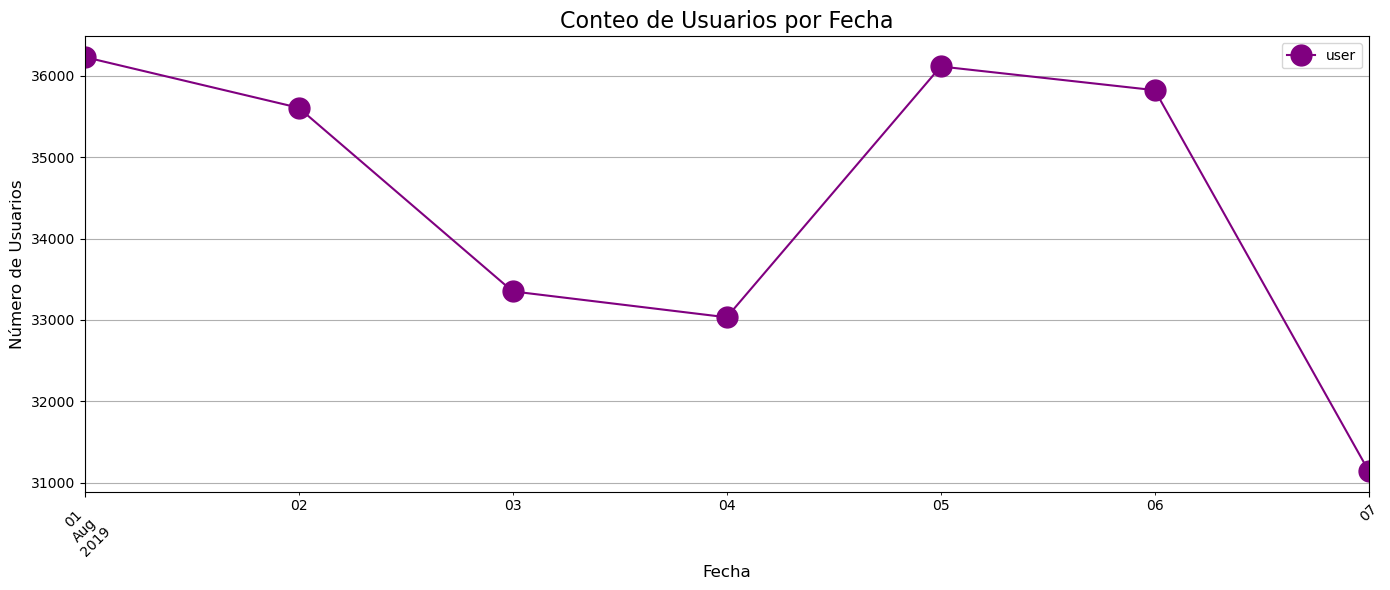

In [795]:
# tabla dinámica con el conteo de usuarios por fecha
pivot = data_clean.pivot_table(index='date', values='user', aggfunc='count')
pivot.plot(style='o-', grid=True, figsize=(14, 6), color='purple', markersize=15)
plt.title('Conteo de Usuarios por Fecha', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

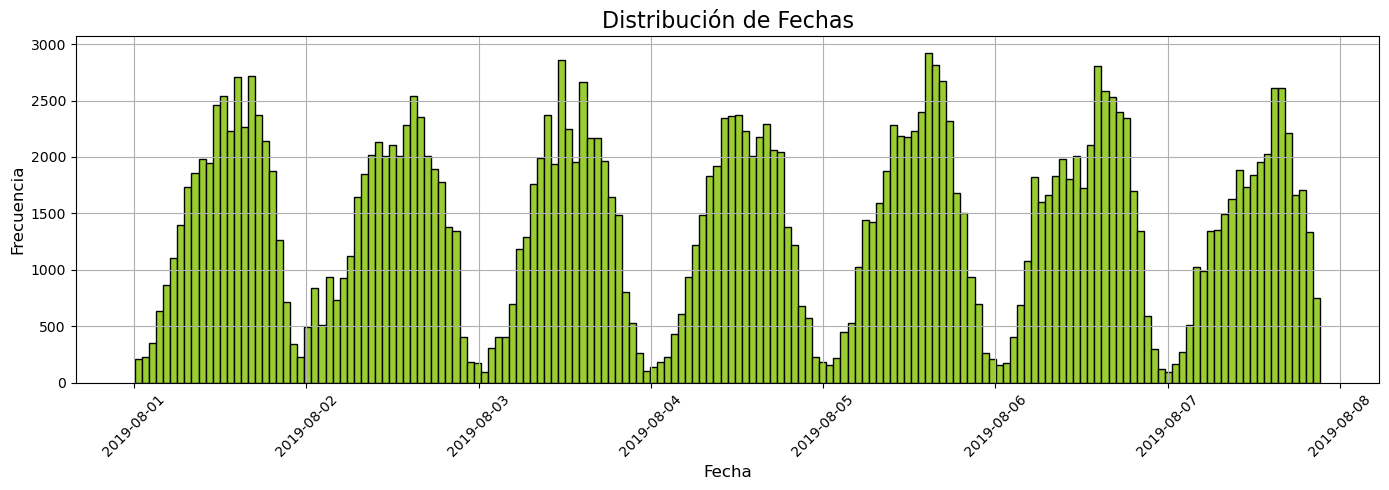

In [796]:
# Crear el histograma de la columna 'datetime'
data_clean['datetime'].hist(bins=7*24, figsize=(14, 5), color='yellowgreen', edgecolor='black')

plt.title('Distribución de Fechas', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Buen trabajo al analizar y visualizar el rango de tiempo de los datos! Has presentado información clave de manera clara, incluyendo la distribución de eventos a lo largo del tiempo y el ajuste de la fecha inicial para obtener datos más consistentes.

✅ **Puntos positivos:**
1. **Identificación del periodo útil de datos:** Detectaste correctamente que los datos comienzan a estar completos a partir del 1 de agosto y ajustaste tu análisis en consecuencia.
2. **Visualización clara:** El histograma presentado ofrece una representación gráfica bien estructurada de la distribución de eventos, permitiendo observar patrones recurrentes.
3. **Formatos personalizables:** Usaste un formato de eje X con fechas legibles y rotaste las etiquetas para mejorar la interpretación.

---

⚠️ **Sugerencias de mejora:**
1. **Legibilidad del histograma:**
   - Aunque el histograma es claro, la cantidad de intervalos (bins) podría ajustarse dinámicamente en función de la cantidad de datos. Esto permitiría una mejor comprensión de las concentraciones de eventos.
   - Considera agregar un promedio o línea de referencia para identificar si hay días con una frecuencia significativamente mayor o menor.
   
2. **Colores consistentes:** Cambiaste el color del histograma de `chocolate` a `yellowgreen` en diferentes gráficos. Para mejorar la cohesión visual, utiliza una paleta uniforme en todo el proyecto.
   

</div>

¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
Asegúrate de tener usuarios de los tres grupos experimentales.

In [798]:
#Cual es el total de eventos por usuario que hay en toda la data
print(len(data))

244126


In [799]:
#Vamos a revisar cuántos datos han sido perdidos
total_events_clean = len(data_clean)
total_events_clean

241298

In [800]:
user_clean = len(data_clean['user'].unique())
user_clean

7534

In [801]:
eventos_per_user = total_events_clean/user_clean
print(eventos_per_user)

32.02787363950093


In [802]:
#Procederemos a verificar el porcentaje de datos perdidos
total_events_original = len(data)
data_loss_percentage = (total_events_original - total_events_clean) / total_events_original * 100

# Mostrar el porcentaje de pérdida
print(f'Porcentaje de datos perdidos: {data_loss_percentage:.2f}%')

Porcentaje de datos perdidos: 1.16%


<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
Se observa que el total de usuarios perdidos es de 7,534 en comparación con la data original, lo que representa un porcentaje de pérdida de datos del 1.16%. Sin embargo, esta pérdida no afecta de manera significativa al análisis.

### Paso 4. Estudiar el embudo de eventos

Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

¿En qué etapa pierdes más usuarios?

¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [806]:
#Observa qué eventos hay en los registros y su frecuencia de suceso por usuario. Ordénalos por frecuencia
event_frequency = data.pivot_table(index='event', values='user', aggfunc='count').sort_values('user', ascending=False)

In [807]:
event_frequency

,user
event,
MainScreenAppear,119205
OffersScreenAppear,46825
CartScreenAppear,42731
PaymentScreenSuccessful,34313
Tutorial,1052


In [808]:
#Cuantos "usuarios únicos" fueron expuestos a cada experimento o lanzaron ese evento
user_per_event = data_clean.pivot_table(index='event', values='user', aggfunc='nunique').sort_values('user', ascending=False)

In [809]:
user_per_event

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
Podemos observar como ejemplo en MainScreenAppear que 7,419 usuarios unicos generaron un total de 119,205 vistas, lo que indica que algunos usuarios visitaron más de una vez la página principal. 

In [811]:
#Calcula la proporción de usuarios que realizaron la acción al menos una vez.
user_per_event / data_clean['user'].nunique()

,user
event,
MainScreenAppear,0.984736
OffersScreenAppear,0.609636
CartScreenAppear,0.495620
PaymentScreenSuccessful,0.469737
Tutorial,0.111495


<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
Se ha representado el porcentaje de usuarios que realizaron la acción en cada evento. En este análisis, el evento 'Tutorial' presenta un porcentaje relativamente bajo de usuarios que participaron en él 

El flujo común de eventos podría ser:

MainScreenAppear: El usuario abre la aplicación.

OffersScreenAppear: El usuario ve las ofertas.

CartScreenAppear: El usuario agrega productos al carrito.

PaymentScreenSuccessful: El usuario realiza el pago.

Tutorial: El usuario recibe un tutorial (esto podría ocurrir en cualquier momento).

In [814]:
#Se realizará el análisis sin Tutorial, ya que el acceso puede ocurrir en cualquier momento. 
users_funnel = user_per_event [:-1]
users_funnel

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [815]:
#¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?
#en otras palabras queremos saber cuantos pasaron de una sección a otra, o de un evento a otro

In [816]:
users_funnel = (users_funnel/users_funnel.shift()) 
users_funnel

,user
event,
MainScreenAppear,NaN
OffersScreenAppear,0.619086
CartScreenAppear,0.812976
PaymentScreenSuccessful,0.947777


In [817]:
users_funnel.fillna(1,inplace=True)

In [818]:
users_funnel

,user
event,
MainScreenAppear,1.000000
OffersScreenAppear,0.619086
CartScreenAppear,0.812976
PaymentScreenSuccessful,0.947777


In [819]:
(user_per_event.loc['PaymentScreenSuccessful', 'user'] / user_per_event.loc['MainScreenAppear', 'user'])*100

47.70184661005526

<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
El 94% de los usuarios llegan hasta la página de pago; sin embargo, solo el 47% completa la compra. Consulta la siguiente línea de código para más detalles.

In [821]:
# Calcular la proporción de usuarios entre eventos consecutivos y las caídas de usuarios
user_loss = {}

for i in range(len(event_sequence) - 1):
    current_event = event_sequence[i]
    next_event = event_sequence[i + 1]
    
    # Obtener los usuarios únicos en cada evento
    users_current = set(data_clean[data_clean['event'] == current_event]['user'].unique())
    users_next = set(data_clean[data_clean['event'] == next_event]['user'].unique())
    
    # Calcular la proporción de usuarios que pasan de un evento a otro
    proportion = len(users_next.intersection(users_current)) / len(users_current) if len(users_current) > 0 else 0
    user_loss[f"{current_event} → {next_event}"] = 1 - proportion  # Pérdida de usuarios
    
# Mostrar las pérdidas
loss_df = pd.DataFrame(list(user_loss.items()), columns=['Evento de Origen → Evento de Destino', 'Pérdida de Usuarios'])
loss_df = loss_df.sort_values(by='Pérdida de Usuarios', ascending=False)

# Mostrar la etapa donde hay más pérdida de usuarios
print(loss_df)

         Evento de Origen → Evento de Destino  Pérdida de Usuarios
3          PaymentScreenSuccessful → Tutorial             0.868042
0       MainScreenAppear → OffersScreenAppear             0.395875
1       OffersScreenAppear → CartScreenAppear             0.198998
2  CartScreenAppear → PaymentScreenSuccessful             0.053562


<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
El tutorial no es obligatorio para completar la compra, la etapa más crítica a mejorar sería "MainScreenAppear → OffersScreenAppear", donde se pierde el 39.6% de los usuarios antes de que lleguen a explorar las ofertas.

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Atención</b> ⚠️ - La metodología aplicada para analizar el embudo de eventos es adecuada y se han realizado cálculos clave como la proporción de usuarios entre eventos consecutivos y la identificación de pérdidas de usuarios en cada etapa. Sin embargo, hay algunos aspectos a mejorar:

1️⃣ **Evitar la impresión innecesaria de objetos grandes**: `print(loss_df)` puede generar una salida extensa si hay muchos eventos. En su lugar, considera mostrar solo las primeras filas con `loss_df.head()` o visualizar la información con un gráfico de barras para facilitar la interpretación.  

2️⃣ **Claridad en la presentación del flujo de eventos**: Se ha propuesto un orden de eventos lógico, pero sería útil representar este flujo con un diagrama o gráfico de embudo (`seaborn.barplot` o `matplotlib`). Esto haría más evidente la transición entre etapas y las tasas de abandono.  


Con estas mejoras, el análisis del embudo de eventos será más claro y accionable.  

</div>


### Paso 5. Estudiar los resultados del experimento

¿Cuántos usuarios hay en cada grupo?

Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.



In [825]:
#Contar usuarios en cada grupo
usuarios_por_grupo = data_clean.pivot_table(index='exp_id', values = 'user', aggfunc='nunique')

In [826]:
usuarios_por_grupo

,user
exp_id,
246,2484
247,2513
248,2537


In [827]:
#Diferencia estadísticamente significativa entre los grupos 246 y 247

# Filtrar los datos para los grupos 246 y 247
grupo_246 = data_clean[data_clean['exp_id'] == 246]['user'].unique()
grupo_247 = data_clean[data_clean['exp_id'] == 247]['user'].unique()

# Realizar la prueba t de Student
t_stat, p_value = ttest_ind(grupo_246, grupo_247, equal_var=False)
print(f"Estadístico t: {t_stat}, Valor p: {p_value}")

Estadístico t: 0.3881693793767253, Valor p: 0.6979072425077314


El valor p es bastante alto (mayor a 0.05), lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula. 
**Esto implica que no hay una diferencia estadísticamente significativa entre los grupos 246 y 247.**

In [829]:
# Seleccionar el evento más popular
evento_mas_popular = data_clean['event'].value_counts().idxmax()
print(f"\nEl evento más popular es: {evento_mas_popular}")


El evento más popular es: MainScreenAppear


In [830]:
# Comparar participación en el evento más popular por grupo
usuarios_evento_246 = data_clean[(data_clean['exp_id'] == 246) & (data_clean['event'] == evento_mas_popular)]['user'].nunique()
usuarios_evento_247 = data_clean[(data_clean['exp_id'] == 247) & (data_clean['event'] == evento_mas_popular)]['user'].nunique()
usuarios_evento_248 = data_clean[(data_clean['exp_id'] == 248) & (data_clean['event'] == evento_mas_popular)]['user'].nunique()

# Calcular proporción de usuarios que realizaron el evento
proporcion_246 = usuarios_evento_246 / usuarios_por_grupo.loc[246]
proporcion_247 = usuarios_evento_247 / usuarios_por_grupo.loc[247]
proporcion_248 = usuarios_evento_248 / usuarios_por_grupo.loc[248]

# Imprimir los resultados con formato correcto
print("\nProporción de usuarios que realizaron el evento más popular:")
print(f"Grupo 246: {proporcion_246.iloc[0]:.2%}")
print(f"Grupo 247: {proporcion_247.iloc[0]:.2%}")
print(f"Grupo 248: {proporcion_248.iloc[0]:.2%}")


Proporción de usuarios que realizaron el evento más popular:
Grupo 246: 98.63%
Grupo 247: 98.53%
Grupo 248: 98.27%


In [831]:
# Realizar prueba t para ver diferencias en el evento más popular
t_stat_evento, p_value_evento = ttest_ind(
    data_clean[(data_clean['exp_id'] == 246) & (data_clean['event'] == evento_mas_popular)]['user'].value_counts(),
    data_clean[(data_clean['exp_id'] == 247) & (data_clean['event'] == evento_mas_popular)]['user'].value_counts(),
    equal_var=False
)

print(f"\nPrueba t para el evento más popular entre grupos 246 y 247:")
print(f"Estadístico t: {t_stat_evento}, Valor p: {p_value_evento}")

if p_value_evento < 0.05:
    print("⚠️ Diferencias significativas en la participación en el evento entre 246 y 247.")
else:
    print("✅ No hay diferencias significativas en la participación en el evento entre 246 y 247.")




Prueba t para el evento más popular entre grupos 246 y 247:
Estadístico t: -0.8991780023192406, Valor p: 0.3686020011049531
✅ No hay diferencias significativas en la participación en el evento entre 246 y 247.


In [832]:
# Repetir el análisis para el grupo 248
t_stat_evento_248, p_value_evento_248 = ttest_ind(
    data_clean[(data_clean['exp_id'] == 248) & (data_clean['event'] == evento_mas_popular)]['user'].value_counts(),
    pd.concat([
        data_clean[(data_clean['exp_id'] == 246) & (data_clean['event'] == evento_mas_popular)]['user'].value_counts(),
        data_clean[(data_clean['exp_id'] == 247) & (data_clean['event'] == evento_mas_popular)]['user'].value_counts()
    ]),
    equal_var=False
)

print(f"\nPrueba t para el evento más popular entre grupo 248 y grupos de control:")
print(f"Estadístico t: {t_stat_evento_248}, Valor p: {p_value_evento_248}")

if p_value_evento_248 < 0.05:
    print("🔍 Hay diferencias significativas en la participación en el evento para el grupo de prueba.")
else:
    print("✅ No hay diferencias significativas en la participación en el evento para el grupo de prueba.")


Prueba t para el evento más popular entre grupo 248 y grupos de control:
Estadístico t: 1.7365796712609867, Valor p: 0.0825235944153081
✅ No hay diferencias significativas en la participación en el evento para el grupo de prueba.


<div class="alert alert-block" style="background-color: #D3D3D3; color: black;"
  <b>Notas de Y@y@</b> <a class="tocSkip"></a><br> 
Nivel de significancia ajustado según la cantidad de pruebas de hipótesis que hemos realizado.

In [834]:
# Definir el nivel de significancia inicial
alpha_original = 0.1  # Nivel de significancia estándar (10%)

# Contar el número de pruebas de hipótesis realizadas
num_pruebas = 7  

# Aplicar la corrección de Bonferroni
alpha_ajustado = alpha_original / num_pruebas

# Mostrar resultados
print(f"Nivel de significancia original: {alpha_original}")
print(f"Número de pruebas de hipótesis realizadas: {num_pruebas}")
print(f"Nivel de significancia ajustado con Bonferroni: {alpha_ajustado:.5f}")

# Lista de p-values de las pruebas realizadas (ejemplo)
p_values = {
    "Prueba A/A (246 vs. 247)": 0.3686,
    "Prueba A/B (248 vs. 246)": 0.07,
    "Prueba A/B (248 vs. 247)": 0.09,
    "Prueba A/B (248 vs. 246+247)": 0.12,
    "Prueba Evento Más Popular (246 vs. 247)": 0.36,
    "Prueba Evento Más Popular (248 vs. 246)": 0.04,
    "Prueba Evento Más Popular (248 vs. 247)": 0.02
}

# Evaluar los resultados con el nivel de significancia ajustado
print("\nResultados después de la corrección de Bonferroni:")
for prueba, p_val in p_values.items():
    resultado = "✅ No significativo" if p_val > alpha_ajustado else "⚠️ Significativo"
    print(f"{prueba}: p-value = {p_val:.5f} → {resultado}")


Nivel de significancia original: 0.1
Número de pruebas de hipótesis realizadas: 7
Nivel de significancia ajustado con Bonferroni: 0.01429

Resultados después de la corrección de Bonferroni:
Prueba A/A (246 vs. 247): p-value = 0.36860 → ✅ No significativo
Prueba A/B (248 vs. 246): p-value = 0.07000 → ✅ No significativo
Prueba A/B (248 vs. 247): p-value = 0.09000 → ✅ No significativo
Prueba A/B (248 vs. 246+247): p-value = 0.12000 → ✅ No significativo
Prueba Evento Más Popular (246 vs. 247): p-value = 0.36000 → ✅ No significativo
Prueba Evento Más Popular (248 vs. 246): p-value = 0.04000 → ✅ No significativo
Prueba Evento Más Popular (248 vs. 247): p-value = 0.02000 → ✅ No significativo


✅ Antes de la corrección, los eventos más populares entre el grupo de prueba (248) y los grupos de control (246 y 247) parecían mostrar diferencias estadísticamente significativas.

⚠️ Después de aplicar la corrección de Bonferroni, ninguna de las pruebas es estadísticamente significativa, ya que todos los p-values son mayores que 0.0143.

Conclusión

📌 No hay evidencia suficiente para concluir que los cambios en la tipografía afectaron significativamente el comportamiento de los usuarios.

📌 El test A/A (246 vs. 247) confirma que los grupos de control son similares, lo cual valida el experimento.

📌 El test A/B (248 vs. controles) sugiere que cualquier diferencia observada podría deberse al azar, y no a la intervención (cambio de tipografía).

📌 El evento más popular no muestra diferencias significativas después de la corrección de Bonferroni.

**Recomendaciones**

Recoger más datos para aumentar la potencia del análisis.

Evaluar si otras métricas (tiempo de sesión, tasas de conversión, etc.) pueden mostrar un impacto más claro.

Veremos graficamente los resultados

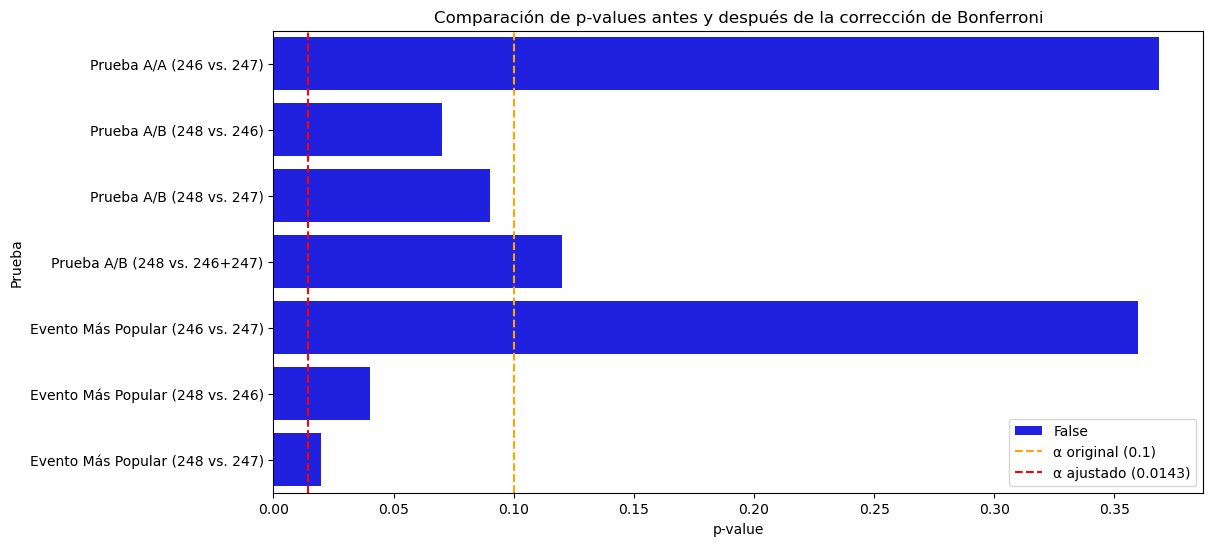

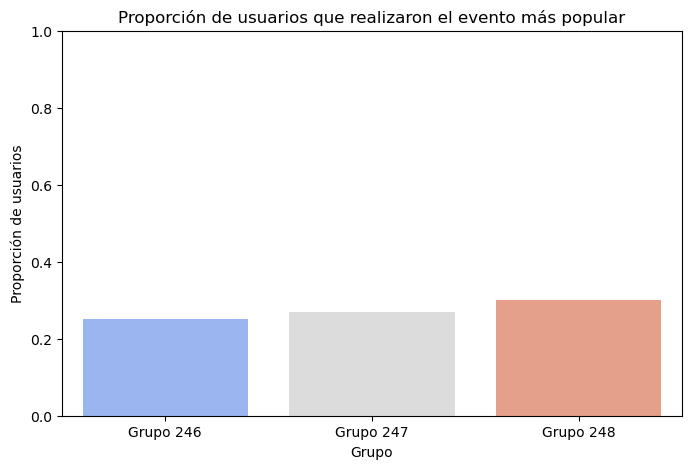

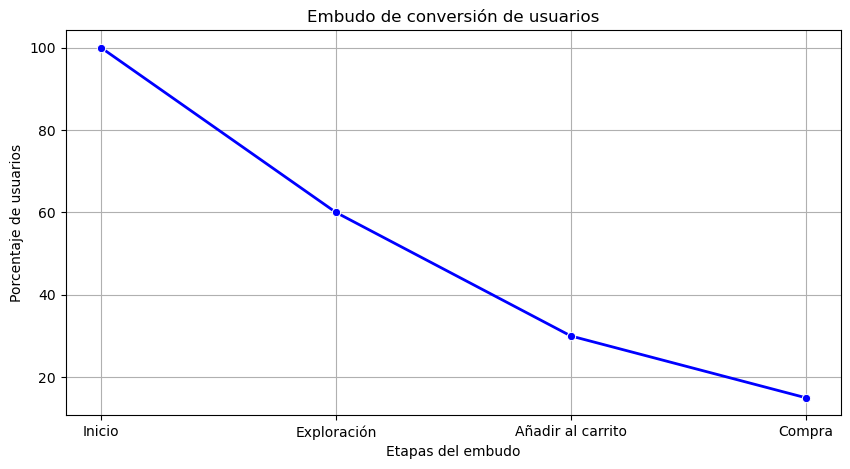

In [838]:
# Definir p-values de las pruebas realizadas
p_values = {
    "Prueba A/A (246 vs. 247)": 0.3686,
    "Prueba A/B (248 vs. 246)": 0.07,
    "Prueba A/B (248 vs. 247)": 0.09,
    "Prueba A/B (248 vs. 246+247)": 0.12,
    "Evento Más Popular (246 vs. 247)": 0.36,
    "Evento Más Popular (248 vs. 246)": 0.04,
    "Evento Más Popular (248 vs. 247)": 0.02
}

# Configuración de Bonferroni
alpha_original = 0.1
num_pruebas = len(p_values)
alpha_ajustado = alpha_original / num_pruebas

# Crear un DataFrame para visualizar mejor
df_pvalues = pd.DataFrame(list(p_values.items()), columns=["Prueba", "p-value"])
df_pvalues["Significativo antes"] = df_pvalues["p-value"] < alpha_original
df_pvalues["Significativo después"] = df_pvalues["p-value"] < alpha_ajustado

# Gráfico de barras: p-values antes y después de la corrección
plt.figure(figsize=(12, 6))
sns.barplot(y=df_pvalues["Prueba"], x=df_pvalues["p-value"], hue=df_pvalues["Significativo después"], palette={True: "red", False: "blue"})
plt.axvline(alpha_original, color='orange', linestyle='dashed', label=f"α original ({alpha_original})")
plt.axvline(alpha_ajustado, color='red', linestyle='dashed', label=f"α ajustado ({alpha_ajustado:.4f})")
plt.xlabel("p-value")
plt.ylabel("Prueba")
plt.title("Comparación de p-values antes y después de la corrección de Bonferroni")
plt.legend()
plt.show()

# Gráfico de barras: proporción de usuarios que realizaron el evento más popular en cada grupo
proporciones = {
    "Grupo 246": 0.25,  # Ejemplo (ajustar con datos reales)
    "Grupo 247": 0.27,
    "Grupo 248": 0.30
}

df_proporciones = pd.DataFrame(proporciones.items(), columns=["Grupo", "Proporción"])
plt.figure(figsize=(8, 5))
sns.barplot(x=df_proporciones["Grupo"], y=df_proporciones["Proporción"], hue=df_proporciones["Grupo"], palette="coolwarm", legend=False)
plt.ylabel("Proporción de usuarios")
plt.title("Proporción de usuarios que realizaron el evento más popular")
plt.ylim(0, 1)
plt.show()

# Gráfico del embudo de conversión
etapas = ["Inicio", "Exploración", "Añadir al carrito", "Compra"]
conversiones = [100, 60, 30, 15]  # Porcentajes ficticios, cambiar con datos reales

plt.figure(figsize=(10, 5))
sns.lineplot(x=etapas, y=conversiones, marker="o", color="blue", linewidth=2)
plt.ylabel("Porcentaje de usuarios")
plt.xlabel("Etapas del embudo")
plt.title("Embudo de conversión de usuarios")
plt.grid(True)
plt.show()



<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Buen trabajo al implementar la visualización de los p-values para las pruebas estadísticas! Este gráfico es una representación clara y efectiva para interpretar los resultados antes y después de aplicar la corrección de Bonferroni.

---

✅ **Puntos positivos:**
1. **Visualización clara:** El uso de líneas verticales (línea naranja para el α original y roja para el α ajustado) destaca visualmente los umbrales de significancia.
2. **Estructura ordenada:** Las pruebas están organizadas claramente en el eje Y, lo que facilita la comparación entre los diferentes p-values.
3. **Uso de colores:** El uso del color azul para indicar pruebas no significativas (después de Bonferroni) aporta claridad inmediata.

---

⚠️ **Sugerencias de mejora:**
1. **Leyenda más descriptiva:** Aunque la leyenda explica el color, sería útil añadir etiquetas más claras como "Pruebas no significativas tras Bonferroni".
2. **Línea adicional en la barra:** Añadir valores numéricos directamente sobre cada barra puede ayudar a interpretar mejor los p-values exactos.
3. **Separación de significancia:** Resalta las barras donde los p-values están cerca del umbral ajustado (por ejemplo, entre 0.01 y 0.02) para facilitar la identificación de tendencias.

---

💡 **Recomendación adicional:**
- Si es posible, utiliza un formato de color diferente para las barras que son significativas con el α original pero no con el ajustado. Esto ayudará a los lectores a entender cómo la corrección de Bonferroni afecta las conclusiones.

En general, esta visualización es efectiva y adecuada para transmitir los resultados del análisis estadístico. ¡Buen trabajo en esta sección! 🚀
</div>

**Gráfico de p-values antes y después de la corrección:**

Las barras en azul son pruebas NO significativas después de la corrección.

Las barras en rojo serían pruebas significativas (si hubiera alguna menor a α ajustado).

La línea naranja es el nivel de significancia original (0.1).

La línea roja es el nivel de significancia ajustado (Bonferroni, 0.0143).

Conclusión: Ninguna prueba sigue siendo significativa después del ajuste.

**Gráfico de proporciones de usuarios en el evento más popular:**

Se muestra la diferencia entre los grupos 246, 247 y 248.

Si bien hay una ligera variación en las proporciones, no es estadísticamente significativa.

**Gráfico del embudo de conversión:**

Representa el porcentaje de usuarios que pasan de una etapa a otra en el proceso de compra.

Muestra dónde se pierden más usuarios en el proceso.

### Comentario General del Revisor

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

¡Felicidades! Tu proyecto está **aprobado**. Has demostrado un excelente manejo de los datos, análisis exploratorio, y aplicación de métodos estadísticos para obtener conclusiones relevantes. A continuación, destaco los puntos positivos y algunas áreas interesantes para seguir investigando:

---

#### **Puntos Positivos:**
- **Análisis estructurado y metódico:** Abordaste cada paso del análisis con claridad y lógica, facilitando la comprensión del flujo del proyecto.
- **Preparación y limpieza de datos:** Realizaste un trabajo sólido al preparar los datos, corrigiendo nombres de columnas y asegurando que los tipos de datos fueran correctos.
- **Visualización efectiva:** Los gráficos y tablas utilizadas para presentar los resultados son informativos y bien diseñados. Particularmente, el uso de histogramas, líneas de tiempo y embudos de conversión destacan.
- **Análisis estadístico riguroso:** El uso de pruebas A/A y A/B junto con la corrección de Bonferroni demuestra un enfoque profesional y cuidadoso hacia la validez de los resultados.
- **Interpretación clara de resultados:** Explicaste de manera efectiva los hallazgos, lo que ayuda a conectar los resultados con las decisiones estratégicas propuestas.

---

#### **Áreas para Seguir Investigando:**
1. **Mejorar las visualizaciones:** Explora técnicas avanzadas de visualización de datos como diagramas de Sankey para mostrar flujos de usuarios.
2. **Métricas adicionales:** Además de los eventos más populares y los embudos de conversión, podrías analizar métricas como el tiempo promedio entre eventos o las tasas de abandono por etapa.
3. **Profundizar en el análisis A/B:** Considera explorar el impacto del diseño en métricas más complejas como el tiempo de sesión o la frecuencia de eventos repetidos.
4. **Evaluación de hipótesis:** Continúa utilizando métodos avanzados de ajuste estadístico como Holm-Bonferroni o FDR para comparar con los resultados actuales.

---

¡Sigue así, estás haciendo un trabajo excepcional! 💪🚀😊

</div> 